### Dataset: 
https://www.kaggle.com/code/dubradave/hcp-shift-bookings-cancellation-trends-eda (comments in the posted notebook indicate that the data set has been generated through software used by Cleveland healthcare facilities and providers)

### Audience:
 Health care organization's leadership both on the business and technical level. The purpose of the project is to gain insight into what variables influence shift cancellations and to determine whether machine learning can be used to predict or forecast cancellations.

### Problem statement:
The three data sets contain several variables that may relate to the healthcare facilities' quality of service, employee satisfaction, and system efficiency. For example:
* No-show cancelations may lead to shifts being short-staffed, impacting patients and staff
* Cancelations may point to unpopular facilities or shifts requiring improvement or additional incentives
* Cancelations may lead to increased administrative overhead

The following questions could be investigated in the context of these points :
#### Business focus:
* Quesetion 1: Are there any facilities, shifts, or provider types with cancellation rates higher than others  (measured in number of cancellations per number of shifts for a given day or other timeframe)? Is there any trend over time?
* Question 2: Same as question 1, but for no-show cancellations. 
* Question 3: Is there any indication that canceled shifts lead to additional work for administrators (e.g., if there are any categories in question 2 that have a higher percentage of cancellations, is that reflected in a higher percentage of bookings by administrators for these facilities, providers, shifts)?
#### Technical focus:
* Question 4: Can a classification model be used to predict what shifts will be cancelled? Useful models will either allow to pin-point the top variables that affect whether a shift will be canceled or not, or predict very accuratly (preferably both).
* Question 5: Can time series analysis be used to predict future developement in shift cancellations, e.g., to alert administrators that re-scheduling will be required?

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import datetime

# Suffixes added to identify source table after merges/joins
# Shifts booked by individual health care workers
df_bookings = pd.read_csv('../data/raw/cleveland_booking_logs.csv').add_suffix('_book')
# Shifts cancelled by individual health care workers
df_cancel = pd.read_csv('../data/raw/cleveland_cancel_logs.csv').add_suffix('_cancel')
# Shifts created by health care facilities
df_shifts = pd.read_csv('../data/raw/cleveland_shifts.csv').add_suffix('_shift')

#Xmas & NYE range from 12-18 through the Tuesday after NYE
xmas_start = datetime.datetime(2021, 12, 18) 
xmas_end = datetime.datetime(2022, 1, 4) 

#Thanksgiving
thx_start = datetime.datetime(2021, 11, 24) 
thx_end = datetime.datetime(2021, 11, 29) 

In [2]:
df_shifts.head(2)

,ID_shift,Agent ID_shift,Facility ID_shift,Start_shift,Agent Req_shift,End_shift,Deleted_shift,Shift Type_shift,Created At_shift,Verified_shift,Charge_shift,Time_shift
0,61732a2ad690c401690cf273,614627661afb050166fecd99,5f9c169622c5c50016d5ba32,2021-10-27 23:00:00,LVN,2021-10-28 3:00:00,NaN,pm,2021-10-22 21:16:26,True,43.0,4.17
1,61732a4fd690c401690cf307,60d5f4c8a9b88a0166aedaca,5f9c169622c5c50016d5ba32,2021-10-28 11:00:00,CNA,2021-10-28 19:00:00,NaN,am,2021-10-22 21:17:04,True,25.0,5.00


In [3]:
colNames = {'ID_shift':'id_shift', 
            'Agent ID_shift':'agent_id_shift', 
            'Facility ID_shift':'facility_id_shift', 
            'Start_shift':'start_shift',
            'Agent Req_shift':'agent_req_shift', 
            'End_shift':'end_shift', 
            'Deleted_shift':'deleted_shift', 
            'Shift Type_shift':'shift_type_shift',
            'Created At_shift':'created_at_shift', 
            'Verified_shift':'verified_shift', 
            'Charge_shift':'charge_shift', 
            'Time_shift':'time_shift'}
df_shifts.rename(columns = colNames,inplace=True)

In [4]:
#df_shifts transformations

#1st Shift is 8am to 4pm
#2nd Shift is 4pm to Midnight
#3rd Shift is Midnight to 8am

""" # Function to return shift value given hour of the day
def determineShift(hourOfDay):
    retVal = None
    if hourOfDay in range(0,8):
        retVal = 3
    elif hourOfDay in range(8,16):
        retVal = 1
    else:
        retVal = 2
    return retVal """

df_shifts['end_shift'] = pd.to_datetime(df_shifts['end_shift'], format='mixed')
df_shifts['created_at_shift'] = pd.to_datetime(df_shifts['created_at_shift'], format='mixed')

df_shifts['start_shift'] = pd.to_datetime(df_shifts['start_shift'], format='mixed')
df_shifts['dayOfWeek_shift'] = df_shifts['start_shift'].apply(lambda x: x.dayofweek)
df_shifts['hourOfDay_shift'] = df_shifts['start_shift'].apply(lambda x: x.hour)
df_shifts['day_shift'] = df_shifts['start_shift'].apply(lambda x: x.date())
# cwitt: this is just a different version of shift_type_shift (am, pm, noc) - not better either...
#df_shifts['workShift_shift'] = df_shifts['hourOfDay_shift'].apply(determineShift)

# cwitt: not sure that's so useful
#create 'day_shift_shift' for plotting
#df_shifts['day_shift_shift'] = (df_shifts['dayOfWeek_shift'].astype(str) + " - " + df_shifts['workShift_shift'].astype(str))

#There are instances of 0 charge_shift (needs to be fixed by eng team), assuming mean for now
df_shifts.loc[(df_shifts['charge_shift'] <= 0), 'charge_shift'] = np.nan
df_shifts['charge_shift'].fillna(df_shifts['charge_shift'].mean(),inplace=True)

#There are shifts with 0 and negative time_shift (needs to be fixed by eng team), assuming mean for now
df_shifts.loc[(df_shifts['time_shift'] <= 0), 'time_shift'] = np.nan
df_shifts['time_shift'].fillna(df_shifts['time_shift'].mean(),inplace=True)

#Recall CBH take rate is approx 22%
df_shifts['totalComp_shift'] = df_shifts['charge_shift'] * df_shifts['time_shift'] * (1 - 0.22)

#This may be an important one - Cancellation rate for things below full shift (7.5 is most common shift)
df_shifts['short_shift'] = df_shifts['time_shift'].apply(lambda x: True if x < 7.5 else False).astype(bool)

#Holiday Indicator - First working day of 2022 was Tuesday 1-4-2022 - Revising to include the whole first week of 2022
df_shifts['holiday_ind_shift'] = df_shifts['start_shift'].apply(lambda x: True if ((xmas_start <= x <= xmas_end) or (thx_start <= x <= thx_end)) else False ).astype(bool)

#Filling NA in deleted_shift
df_shifts['deleted_shift'].fillna(False,inplace=True)

In [5]:
df_bookings.head(2)

,ID_book,Created At_book,Shift ID_book,Action_book,Worker ID_book,Facility ID_book,Lead Time_book
0,615f58b997538d018b1163e0,2021-10-07 20:29:46,615e1de54502b9016c9a5af1,SHIFT_CLAIM,5c993c695d096c00167e6845,615b46a1c7135401876cdd06,144.504167
1,61608ce36790e5016acaf149,2021-10-08 18:24:35,616060338917ec016965f9a0,SHIFT_CLAIM,61587d5a2ced390187554556,5fbd2a01582f640016a4cb09,200.590278


In [6]:
colNames = {'ID_book':'id_book', 
            'Created At_book':'created_at_book', 
            'Shift ID_book':'shift_id_book',
            'Action_book':'action_book', 
            'Worker ID_book':'worker_id_book', 
            'Facility ID_book':'facility_id_book',
            'Lead Time_book':'lead_time_book'}
df_bookings.rename(columns=colNames, inplace=True)

In [7]:
#df_bookings transformations

df_bookings['created_at_book'] = pd.to_datetime(df_bookings['created_at_book'], format='mixed')
df_bookings['dayOfWeek_book'] = df_bookings['created_at_book'].apply(lambda x: x.dayofweek)
df_bookings['hourOfDay_book'] = df_bookings['created_at_book'].apply(lambda x: x.hour)

df_bookings['shift_datetime_book'] = df_bookings['created_at_book'] + df_bookings['lead_time_book'].apply(lambda x: datetime.timedelta(days = x))
df_bookings['shift_dayOfWeek_book'] = df_bookings['shift_datetime_book'].apply(lambda x: x.dayofweek)

# cwitt: not sure how useful this is...
#Add super user to bookings
""" df_bookings = df_bookings.merge(df_bookings['worker_id_booking'].value_counts().reset_index(),
                                left_on='worker_id_booking',
                                right_on='index',
                                suffixes = ('_x', '_y'))
df_bookings.rename(columns={'worker_id_booking_x':'worker_id_booking',
                            'worker_id_booking_y':'worker_num_bookings'},
                   inplace = True)
df_bookings['super_user'] = df_bookings['worker_num_bookings'].apply(lambda x: True if x >= 100 else False) """;
# cwitt: 
df_bookings['shift_day_book'] = df_bookings['shift_datetime_book'].apply(lambda x: x.date())

In [8]:
df_cancel.head(2)

,ID_cancel,Created At_cancel,Shift ID_cancel,Action_cancel,Worker ID_cancel,Shift Start Logs_cancel,Facility ID_cancel,Lead Time_cancel
0,61a07227f36d1e0186381d10,2021-11-26 5:35:36,619d2f2a5db209018533a507,NO_CALL_NO_SHOW,5e1fa8d8170f34001633e511,2021-11-25 6:00:00,6182c3fb79773801854c081d,-23.593056
1,617bb2e2ae50230185b05985,2021-10-29 8:37:55,614fa1ed22aa37018320e6ed,WORKER_CANCEL,5cf573381648900016c41377,2021-10-29 13:00:00,5ff4f626909f7a00160d06fd,4.368333


In [9]:
colNames = {'ID_cancel':'id_cancel', 
            'Created At_cancel':'created_at_cancel', 
            'Shift ID_cancel':'shift_id_cancel', 
            'Action_cancel':'action_cancel',
            'Worker ID_cancel':'worker_id_cancel', 
            'Shift Start Logs_cancel':'shift_start_logs_cancel', 
            'Facility ID_cancel':'facility_id_cancel',
            'Lead Time_cancel':'lead_time_cancel'}
df_cancel.rename(columns = colNames,inplace=True)

In [10]:
#df_cancel transformations
#datetime metrics of cancellation actions
df_cancel['created_at_cancel'] = pd.to_datetime(df_cancel['created_at_cancel'], format='mixed')
df_cancel['dayOfWeek_cancel'] = df_cancel['created_at_cancel'].apply(lambda x: x.dayofweek)
df_cancel['hourOfDay_cancel'] = df_cancel['created_at_cancel'].apply(lambda x: x.hour)
df_cancel['day_cancel'] = df_cancel['created_at_cancel'].apply(lambda x: x.date)

#datetime metrics of shifts cancelled
df_cancel['shift_start_logs_cancel'] = pd.to_datetime(df_cancel['shift_start_logs_cancel'], format='mixed')
df_cancel['shift_dayOfWeek_cancel'] = df_cancel['shift_start_logs_cancel'].apply(lambda x: x.dayofweek)
df_cancel['shift_hourOfDay_cancel'] = df_cancel['shift_start_logs_cancel'].apply(lambda x: x.hour)
df_cancel['shift_day_cancel'] = df_cancel['shift_start_logs_cancel'].apply(lambda x: x.date())
# cwitt: see shifts table - this is just a different version of shift_type_shift (am, pm, noc) - not better either...
# and: what sense does it make to track whether a shift was cancelled during am, pm, or noc work hours?
#df_cancel['workShift_cancel'] = df_cancel['shift_hourOfDay_cancel'].apply(determineShift)

#create 'day_shift_cancel' for plotting
# cwitt: again, what sense does it make to track whether a shift was cancelled during am, pm, or noc work hours?
#df_cancel['day_shift_cancel'] = (df_cancel['shift_dayOfWeek_cancel'].astype(str) + " - " + df_cancel['workShift_cancel'].astype(str))

#Under 24 hour lead time cancellation indicator
df_cancel['under24_ind'] = df_cancel['lead_time_cancel'] < 24

#cancellation indicator
# cwitt: all shifts in this table are cancelled shifts...
# df_cancel['cancel_indicator'] = 1

#Holiday Indicator - First working day of 2022 was Tuesday 1-4-2022 - Revising to include the whole first week of 2022
# cwitt: unless a cancellation ON a holiday is for a following day holiday, what does it matter?
#df_cancel['holiday_cancel_ind_cancel'] = df_cancel['created_at_cancel'].apply(lambda x: True if ((xmas_start <= x <= xmas_end) or (thx_start <= x <= thx_end)) else False ).astype(bool)
df_cancel['holiday_shift_ind_cancel'] = df_cancel['shift_start_logs_cancel'].apply(lambda x: True if ((xmas_start <= x <= xmas_end) or (thx_start <= x <= thx_end)) else False ).astype(bool)

In [11]:
#Winter storm indicator for Cleveland, Oh
start = datetime.datetime(2022, 1, 14) #Snow starts on the 14th, but gets worse early morning of the 16th
end = datetime.datetime(2022, 1, 28) #Continued to snow through the following week
df_cancel['weather_shift_ind_cancel'] = df_cancel['shift_start_logs_cancel'].apply(lambda x: True if (start <= x < end) else False )
# cwitt: again, does it matter if the weather is bad at a time a shift is cancelled?
# df_cancel['weather_cancel_ind_cancel'] = df_cancel['created_at_cancel'].apply(lambda x: True if (start <= x < end) else False )

# cwitt: revisit; this may be useful, but seems not the most logic place to store here (weather is not a factor when shifts are created... or is it?)
#df_shifts['weather_ind_shift'] = df_shifts['start_shift'].apply(lambda x: True if (start <= x < end) else False )

In [12]:
def basic_summary(df):
    print('data set consists of {} features, {} samples'.format(df.shape[1],df.shape[0]))
    summary = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': 'Feature'})
    summary['Num of Nulls'] = df.isnull().sum().values
    summary['Num of Unique'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    return summary

def summary(df):
    print(df.shape)
    #print(df.dtypes)
    print(df.isna().sum())
    print(df.nunique())
    #print(df.head(3))
basic_summary(df_shifts)

data set consists of 18 features, 41040 samples


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value
0,id_shift,object,0,41040,61732a2ad690c401690cf273,61732a4fd690c401690cf307
1,agent_id_shift,object,20035,997,614627661afb050166fecd99,60d5f4c8a9b88a0166aedaca
2,facility_id_shift,object,0,67,5f9c169622c5c50016d5ba32,5f9c169622c5c50016d5ba32
3,start_shift,datetime64[ns],0,2029,2021-10-27 23:00:00,2021-10-28 11:00:00
4,agent_req_shift,object,0,8,LVN,CNA
5,end_shift,datetime64[ns],0,2549,2021-10-28 03:00:00,2021-10-28 19:00:00
6,deleted_shift,bool,0,2,False,False
7,shift_type_shift,object,0,4,pm,am
8,created_at_shift,datetime64[ns],0,40821,2021-10-22 21:16:26,2021-10-22 21:17:04
9,verified_shift,bool,0,2,True,True


In [13]:
df_shifts.describe()

,start_shift,end_shift,created_at_shift,charge_shift,time_shift,dayOfWeek_shift,hourOfDay_shift,totalComp_shift
count,41040,41040,41040,41040.000000,41040.000000,41040.000000,41040.000000,41040.000000
mean,2021-12-09 19:54:01.404970752,2021-12-10 04:44:29.100877312,2021-11-27 05:56:53.184746496,41.418520,7.645551,3.113938,12.396442,251.642323
min,2021-10-01 00:00:00,2021-10-01 10:00:00,2021-08-16 18:09:54,3.000000,0.330000,0.000000,0.000000,9.750000
25%,2021-11-11 03:30:00,2021-11-11 12:00:00,2021-10-26 19:36:04.750000128,32.000000,7.500000,1.000000,4.000000,163.800000
50%,2021-12-17 12:00:00,2021-12-17 20:00:00,2021-12-01 22:08:58.500000,41.418520,7.500000,3.000000,12.000000,234.000000
75%,2022-01-07 23:00:00,2022-01-08 11:00:00,2021-12-28 10:52:25.500000,47.000000,8.000000,5.000000,20.000000,331.890000
max,2022-01-31 23:30:00,2022-02-01 15:00:00,2022-04-04 19:50:32,120.000000,17.010000,6.000000,23.000000,1241.526000
std,NaN,NaN,NaN,12.196298,2.845731,2.062696,7.204219,134.440900


In [14]:
basic_summary(df_bookings)

data set consists of 12 features, 127005 samples


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value
0,id_book,object,0,127005,615f58b997538d018b1163e0,61608ce36790e5016acaf149
1,created_at_book,datetime64[ns],0,124130,2021-10-07 20:29:46,2021-10-08 18:24:35
2,shift_id_book,object,0,108662,615e1de54502b9016c9a5af1,616060338917ec016965f9a0
3,action_book,object,0,1,SHIFT_CLAIM,SHIFT_CLAIM
4,worker_id_book,object,140,6841,5c993c695d096c00167e6845,61587d5a2ced390187554556
5,facility_id_book,object,0,1118,615b46a1c7135401876cdd06,5fbd2a01582f640016a4cb09
6,lead_time_book,float64,0,122159,144.504167,200.590278
7,dayOfWeek_book,int64,0,7,3,4
8,hourOfDay_book,int64,0,24,20,18
9,shift_datetime_book,datetime64[ns],0,126869,2022-03-01 08:35:46.028800,2022-04-27 08:34:35.019200


In [15]:
df_bookings.describe()

,created_at_book,lead_time_book,dayOfWeek_book,hourOfDay_book,shift_datetime_book,shift_dayOfWeek_book
count,127005,127005.000000,127005.000000,127005.000000,127005,127005.000000
mean,2021-10-25 23:53:30.814314496,200.585881,2.664210,13.886028,2022-05-14 13:57:10.903039488,3.002276
min,2021-08-13 07:34:17,-3271.273333,0.000000,0.000000,2013-04-28 15:42:49.028800,0.000000
25%,2021-10-11 14:18:31,62.488333,1.000000,7.000000,2021-12-30 14:05:52.038400,1.000000
50%,2021-10-27 16:37:34,147.248333,3.000000,16.000000,2022-03-24 05:01:49.990400,3.000000
75%,2021-11-09 18:39:46,282.997500,4.000000,20.000000,2022-08-03 03:25:13.038400,5.000000
max,2022-04-12 22:16:25,2134.461944,6.000000,23.000000,2027-07-08 04:37:29.961600,6.000000
std,NaN,194.605213,1.833591,7.347249,NaN,2.003026


In [16]:
basic_summary(df_cancel)

data set consists of 17 features, 78073 samples


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value
0,id_cancel,object,0,78073,61a07227f36d1e0186381d10,617bb2e2ae50230185b05985
1,created_at_cancel,datetime64[ns],0,77706,2021-11-26 05:35:36,2021-10-29 08:37:55
2,shift_id_cancel,object,0,65562,619d2f2a5db209018533a507,614fa1ed22aa37018320e6ed
3,action_cancel,object,0,2,NO_CALL_NO_SHOW,WORKER_CANCEL
4,worker_id_cancel,object,191,9933,5e1fa8d8170f34001633e511,5cf573381648900016c41377
5,shift_start_logs_cancel,datetime64[ns],0,5000,2021-11-25 06:00:00,2021-10-29 13:00:00
6,facility_id_cancel,object,0,1416,6182c3fb79773801854c081d,5ff4f626909f7a00160d06fd
7,lead_time_cancel,float64,0,71960,-23.593056,4.368333
8,dayOfWeek_cancel,int64,0,7,4,4
9,hourOfDay_cancel,int64,0,24,5,8


In [17]:
df_cancel.describe()

,created_at_cancel,shift_start_logs_cancel,lead_time_cancel,dayOfWeek_cancel,hourOfDay_cancel,shift_dayOfWeek_cancel,shift_hourOfDay_cancel
count,78073,78073,78073.000000,78073.000000,78073.000000,78073.000000,78073.000000
mean,2021-12-09 16:08:06.151640064,2021-12-14 02:02:33.203540480,105.907654,2.961165,12.638338,3.365850,13.488312
min,2021-09-06 11:06:36,2021-10-01 00:00:00,-4210.099722,0.000000,0.000000,0.000000,0.000000
25%,2021-11-13 14:54:04,2021-11-19 15:00:00,2.254167,1.000000,5.000000,1.000000,7.000000
50%,2021-12-14 15:32:46,2021-12-20 22:00:00,36.302778,3.000000,14.000000,4.000000,13.000000
75%,2022-01-07 02:38:42,2022-01-10 20:00:00,200.658056,5.000000,19.000000,5.000000,20.000000
max,2022-07-09 05:05:31,2022-01-31 23:45:00,1854.236667,6.000000,23.000000,6.000000,23.000000
std,NaN,NaN,215.991052,1.986003,7.406484,2.091639,6.752021


In [18]:
# look at facility data
# shifts per facility
print('number of unique facility IDs in shifts:', df_shifts.facility_id_shift.nunique())
df_fac_shifts = df_shifts.facility_id_shift.value_counts().rename_axis('facility_id_shift').reset_index(name='number_shifts')
df_fac_shifts.head(5)

number of unique facility IDs in shifts: 67


,facility_id_shift,number_shifts
0,5f9ad22ae3a95f0016090f97,3138
1,5f9c169622c5c50016d5ba32,2974
2,5f9c119522c5c50016d5b89e,2916
3,5f91b184cb91b40016e1e183,2362
4,5fa0a33daaa281001684ade2,1833


In [19]:
# bookings per facility
print('number of unique facility IDs in bookings:', df_bookings.facility_id_book.nunique())
df_fac_book = df_bookings.facility_id_book.value_counts().rename_axis('facility_id_book').reset_index(name='number_bookings')

number of unique facility IDs in bookings: 1118


In [20]:
# cancels per facility
print('number of unique facility IDs in cancellations:', df_cancel.facility_id_cancel.nunique())
df_fac_cancel = df_cancel.facility_id_cancel.value_counts().rename_axis('facility_id_cancel').reset_index(name='number_cancellations')

number of unique facility IDs in cancellations: 1416


### Takeaway from first look at data:
* There are some signs that data may need some light cleaning:
* Only about 41000 rows in shifts, but 127000 in bookings and 78000 in cancellations
* Only 67 facilities in shifts, but over 1000 facilities in bookings and cancellations. Since the origin of the additional facility IDs is unclear, exclude them from analysis of both facilities and cancellations.
* Shifts start 2021-10-01, end 2022-01-31, but bookings start 2013, end 2027 (going by shift_datetime_book, which contains date of shift calculated from booking date plus lead time) - shift_datetime_book needs to be cleaned to fall between 2021-10-01 and 2022-01-31. Cancellations start 2021-10-01, end 2022-01-31 (going by shift_start_logs_cancel).
* 40000 shifts for 67 facilities for 4 months = 333 shifts per day for 67 facilities (about 5 shifts per facility - this seems very small, but may make sense if these are add-on shifts to cover additional demand, employees taking vacation, etc.)

In [21]:
# some data cleaning: remove bookings for shifts that fall outside of 2021-10-01 - 2022-01-31
# note: previous cell 'bookings per facility' needs to be redone before facility analysis!! (DONE, see next cell)
date_start = pd.to_datetime('2021-10-01')
date_end = pd.to_datetime('2022-01-31')
df_bookings_4mo = df_bookings[(df_bookings.shift_datetime_book >= date_start) & (df_bookings.shift_datetime_book <= date_end)]
df_bookings_4mo.describe()

,created_at_book,lead_time_book,dayOfWeek_book,hourOfDay_book,shift_datetime_book,shift_dayOfWeek_book
count,42526,42526.000000,42526.000000,42526.000000,42526,42526.000000
mean,2021-10-28 07:40:41.428913920,43.199714,2.747707,13.951018,2021-12-10 12:28:16.757160960,3.055519
min,2021-09-25 22:06:38,-56.501111,0.000000,0.000000,2021-10-01 00:31:38.009600,0.000000
25%,2021-10-12 21:38:57,17.006250,1.000000,8.000000,2021-11-17 21:47:09.516800,1.000000
50%,2021-10-27 22:19:21.500000,40.447500,3.000000,16.000000,2021-12-10 17:45:58.028800,3.000000
75%,2021-11-12 04:53:12,67.187569,4.000000,20.000000,2022-01-04 13:25:28.031200,5.000000
max,2021-12-03 02:18:08,125.890278,6.000000,23.000000,2022-01-30 23:58:01.961600,6.000000
std,NaN,31.682457,1.875866,7.287732,NaN,2.007194


In [22]:
print('number of unique facility IDs in bookings:', df_bookings_4mo.facility_id_book.nunique())
df_fac_book = df_bookings_4mo.facility_id_book.value_counts().rename_axis('facility_id_book').reset_index(name='number_bookings')

number of unique facility IDs in bookings: 1050


In [23]:
# facility analysis
# left join to df_fac_shift makes sure only rows with bona fide facility IDs from bookings and cancellations are used
df_fac_merge = pd.merge(df_fac_shifts, df_fac_book, how='left', left_on='facility_id_shift', right_on='facility_id_book')
df_facilities = pd.merge(df_fac_merge, df_fac_cancel, how='left', left_on='facility_id_shift', right_on='facility_id_cancel')
df_facilities.drop(['facility_id_book', 'facility_id_cancel'], inplace=True, axis=1)

print(df_facilities.shape)
print(df_facilities.describe())
basic_summary(df_facilities)

(67, 4)
       number_shifts  number_bookings  number_cancellations
count      67.000000        45.000000             59.000000
mean      612.537313        82.400000            131.864407
std       736.820202       110.648378            149.658169
min         2.000000         1.000000              1.000000
25%        50.500000        14.000000             12.500000
50%       397.000000        36.000000             90.000000
75%       862.500000       111.000000            243.000000
max      3138.000000       632.000000            585.000000
data set consists of 4 features, 67 samples


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value
0,facility_id_shift,object,0,67,5f9ad22ae3a95f0016090f97,5f9c169622c5c50016d5ba32
1,number_shifts,int64,0,64,3138,2974
2,number_bookings,float64,22,42,235.0,632.0
3,number_cancellations,float64,8,48,480.0,289.0


In [24]:
df_facilities.number_bookings.fillna(value=0, inplace=True)
df_facilities.number_cancellations.fillna(value=0, inplace=True);
basic_summary(df_facilities)

data set consists of 4 features, 67 samples


,Feature,Data Type,Num of Nulls,Num of Unique,First Value,Second Value
0,facility_id_shift,object,0,67,5f9ad22ae3a95f0016090f97,5f9c169622c5c50016d5ba32
1,number_shifts,int64,0,64,3138,2974
2,number_bookings,float64,0,43,235.0,632.0
3,number_cancellations,float64,0,49,480.0,289.0


In [25]:
print('total number of shifts:', df_facilities.number_shifts.sum())
print('total number of bookings:', df_facilities.number_bookings.sum())
print('total number of cancellations:', df_facilities.number_cancellations.sum())

total number of shifts: 41040
total number of bookings: 3708.0
total number of cancellations: 7780.0


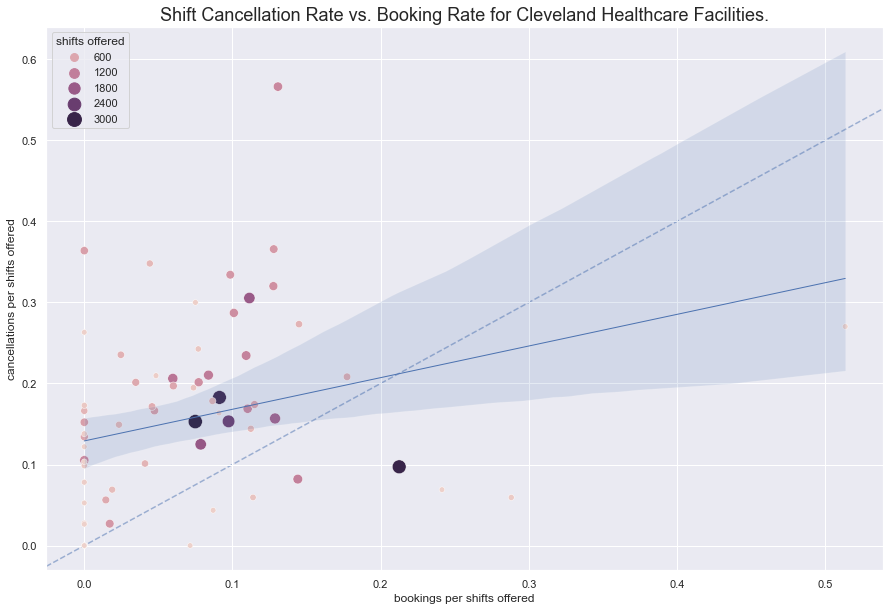

In [49]:
# Even though shifts claimed or cancelled may not all stem from the initial shift table,
# the relative numbers of shifts offered, claimed, and cancelled can be used to compare facilities
df_facilities['bookings_per_shift'] = df_facilities.number_bookings/df_facilities.number_shifts
df_facilities['cancellations_per_shift'] = df_facilities.number_cancellations/df_facilities.number_shifts

# plot cancellation rate vs. booking rate 
sns.set_style("darkgrid", {"axes.facecolor": ".9","grid.color": ".6", "grid.linestyle": ":"})
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.scatterplot(data=df_facilities, x='bookings_per_shift', y='cancellations_per_shift', hue='number_shifts', size='number_shifts', sizes=(30, 200))
# some plots can make a circle - not scatter...
# ax.ax_joint.plot([0.45],[0.33],'o',ms=0.5,mec='r',mfc='none')

# add linear regression with 95% confidence interval - note that this doesn't weight facilities according to number of shifts 
sns.regplot(data=df_facilities, x='bookings_per_shift', y='cancellations_per_shift', scatter=False, line_kws={'lw': '1'});
ax.set_title('Shift Cancellation Rate vs. Booking Rate for Cleveland Healthcare Facilities.', fontdict = {'fontsize': 18});
                            #  'fontweight': 'semibold',
                            #  'color': 'dimgrey'});
plt.legend(title='shifts offered');
ax.set_xlabel('bookings per shifts offered');
ax.set_ylabel('cancellations per shifts offered');
ax.axline((0, 0), slope=1, c="b", ls="--", alpha=0.5,  zorder=0);

In [27]:
# facilities that have neither bookings nor cancellations
df_no_book_or_cancel = df_facilities.loc[(df_facilities.number_bookings == 0) & (df_facilities.number_cancellations == 0)]
df_no_book_or_cancel.shape
df_no_book_or_cancel.head(7)

,facility_id_shift,number_shifts,number_bookings,number_cancellations,bookings_per_shift,cancellations_per_shift
57,5e5849e1e0adc90016335e0e,23,0.0,0.0,0.0,0.0
60,5e727d32759cf60016dd70ca,18,0.0,0.0,0.0,0.0
61,61b396bdc6963001856bbda8,17,0.0,0.0,0.0,0.0
63,5fe0fca507a3ca0016685a28,13,0.0,0.0,0.0,0.0
64,6093f5c353844901664752b9,7,0.0,0.0,0.0,0.0
65,5e72825e759cf60016e11e5a,2,0.0,0.0,0.0,0.0
66,5fa1853b6144d70016b72848,2,0.0,0.0,0.0,0.0


In [28]:
# compare to facilities with the smallest number of shifts
df_facilities.number_shifts.sort_values().head(10)

66     2
65     2
64     7
63    13
62    14
61    17
60    18
59    19
58    19
57    23
Name: number_shifts, dtype: int64

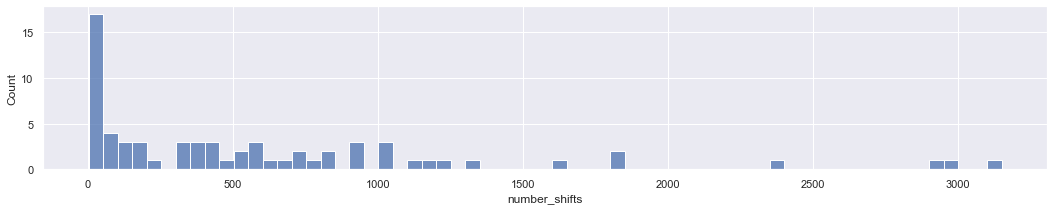

In [29]:
# look at distribution of shift numbers
sns.set(rc={'figure.figsize':(18,3)})
sns.histplot(data=df_facilities, x='number_shifts', binwidth=50);

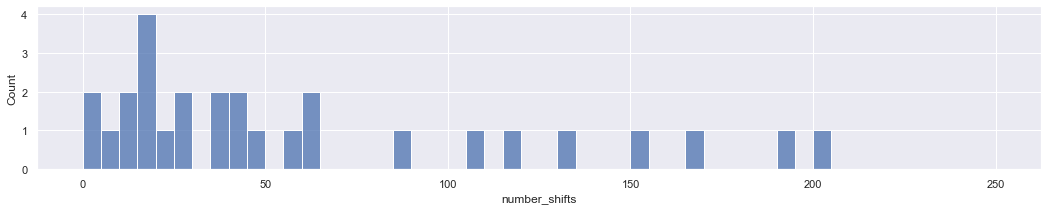

In [30]:
# zoom to small shift numbers
sns.histplot(data=df_facilities, x='number_shifts', binwidth=5, binrange=(0, 250));

In [31]:
# check out the outliers
df_cancel_outl = df_facilities.loc[(df_facilities.cancellations_per_shift > 0.5)]
df_cancel_outl.head()

,facility_id_shift,number_shifts,number_bookings,number_cancellations,bookings_per_shift,cancellations_per_shift
11,5f9b189a7ecb880016516a52,1033,135.0,585.0,0.130687,0.566312


In [32]:
df_book_outl = df_facilities.loc[(df_facilities.bookings_per_shift > 0.5)]
df_book_outl.head()

,facility_id_shift,number_shifts,number_bookings,number_cancellations,bookings_per_shift,cancellations_per_shift
54,60789699e021a90161a8ebff,37,19.0,10.0,0.513514,0.27027


### Takeaway from analysis of facilities:
* Of the 67 facilities that appear in the shift data, 22 have no bookings and 8 have no cancellations. There's strong overlap: 7 facilities have neither. All 7 are among the 10 smallest facilities in terms of shifts offered - all under 25 shifts over 4 months.
* Correlation of booking rate and cancellation rate is fairly week: data points are widely scattered, linear regression line does not have a steep slope (TODO: calculate slope, coefficient? regplot doesn't have the data...)
* There is no apparent correlation between the size of the facility (going by number of shifts offered) and the rate of cancellations and bookings.
* Only 8 facilites have a booking rate that is higher than the cancellation rate. This means for 52 facilities the cancellation rate is higher than the booking rate.
* One facility has a very high booking rate of over 0.5. It is a smaller facility with 37 shifts offered over 4 months.
* One facility has a very high cancellation rate of over 0.5. It is a mid-size facility with 1033 shifts offered.

* TODO: split facilities into popular/unpopular - along dotted line plus 0.15 - see if analysis of cancellations done separately makes a diff
* see if clustering supports the distinction
* add analysis of cancellations based on worker type, shift length (shift type?), comp

In [33]:
# analyze cancellations
# merge cancellations with shift table to get shift type (am/pm/noc), shift length, healthcare worker type, compensation - needs to be inner join on shift id
# will also restrict data to 67 facilities from shift table
df_cancel_67 = pd.merge(df_cancel, df_shifts, how='inner', left_on='shift_id_cancel', right_on='id_shift')
print(df_cancel_67.shape)
print(df_cancel_67.columns.values)
# there are some interesting columns that need additional context
# agent_req_shift - need to compare how many shifts overall per agent type
# shift_type_shift
# short_shift

(7780, 35)
['id_cancel' 'created_at_cancel' 'shift_id_cancel' 'action_cancel'
 'worker_id_cancel' 'shift_start_logs_cancel' 'facility_id_cancel'
 'lead_time_cancel' 'dayOfWeek_cancel' 'hourOfDay_cancel' 'day_cancel'
 'shift_dayOfWeek_cancel' 'shift_hourOfDay_cancel' 'shift_day_cancel'
 'under24_ind' 'holiday_shift_ind_cancel' 'weather_shift_ind_cancel'
 'id_shift' 'agent_id_shift' 'facility_id_shift' 'start_shift'
 'agent_req_shift' 'end_shift' 'deleted_shift' 'shift_type_shift'
 'created_at_shift' 'verified_shift' 'charge_shift' 'time_shift'
 'dayOfWeek_shift' 'hourOfDay_shift' 'day_shift' 'totalComp_shift'
 'short_shift' 'holiday_ind_shift']


### Taking a look at cancellations

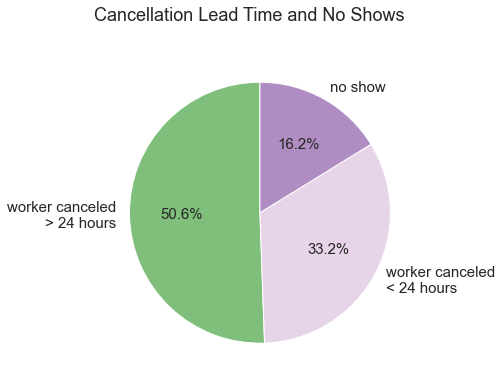

In [34]:
# pick some colors (based on colorbrewer2.org)
gn =  '#7fbf7b'
l_gn = '#d9f0d3'
og = '#af8dc3'
l_og = '#e7d4e8'
gy = 'lightgrey'
kwargs = dict(
    startangle = 90,
    colors = [gn, l_og, og],
    fontsize   = 15,
    figsize    = (12, 6),
    autopct    = '%1.1f%%',
    # title      = '', 
    labels = ["worker canceled\n> 24 hours", "worker canceled\n< 24 hours",  "no show"],
    ylabel=''
)
df_cancel_67['cancel_type'] = df_cancel_67.action_cancel.mask(df_cancel_67.action_cancel == 'WORKER_CANCEL', df_cancel_67.under24_ind)
df_cancel_67.cancel_type.value_counts().plot.pie(**kwargs);
plt.suptitle('Cancellation Lead Time and No Shows', fontsize=18);

# doesn't make sense unless compared to percent of short shifts in shift table
# df_cancel_67.short_shift.value_counts().plot.pie(**kwargs); 

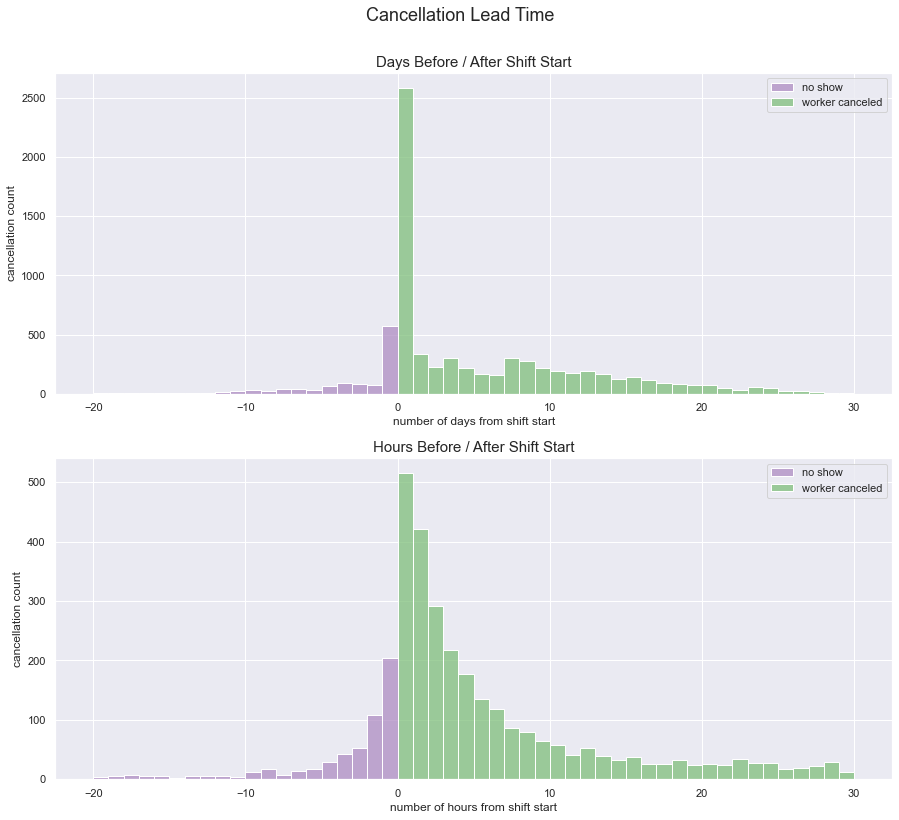

In [35]:
sns.set(rc={'figure.figsize':(15,13)})
# lead time is in hours -> convert to days; also there are some far outliers with counts so low they yields no visible bar -> restrict histogram
df_cancel_67['lead_time_days_cancel'] = df_cancel_67.lead_time_cancel / 24
plt.subplot(2,1, 1)
# doesn't work:
# sns.set_style("darkgrid", { 'axes.facecolor':'white', 'figure.facecolor':'grey'})
# with sns.axes_style("darkgrid", {"axes.facecolor": ".9", "grid.linestyle": ":"}):
sns.histplot(data=df_cancel_67, x="lead_time_days_cancel", hue="action_cancel", multiple="stack", bins=120, palette=[gn, og], legend=False, binwidth=1, binrange=(-20, 30));
plt.title('Days Before / After Shift Start', fontsize=15)
plt.legend(title=None, loc='upper right', labels=['no show', 'worker canceled'])
plt.xlabel('number of days from shift start')
plt.ylabel('cancellation count')
# zoom in to hourly cancellations around shift start
plt.subplot(2,1, 2)
# with sns.axes_style("darkgrid", {"axes.facecolor": ".9", "grid.linestyle": ":"}):
sns.histplot(data=df_cancel_67, x="lead_time_cancel", hue="action_cancel", multiple="stack", bins=2800, palette=[gn, og],  legend=False, binwidth=1, binrange=(-20, 30));
plt.title('Hours Before / After Shift Start',fontsize=15)
plt.legend(title=None, loc='upper right', labels=['no show', 'worker canceled'])
plt.xlabel('number of hours from shift start')
plt.ylabel('cancellation count')
plt.suptitle('Cancellation Lead Time', fontsize=18, y=0.95);

C:\Users\cwitt\AppData\Local\Temp/ipykernel_1624/435454552.py:17: UserWarning: The label '_hide' of <matplotlib.patches.Wedge object at 0x0000015447D130D0> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels=['_hide', '< expected', '_hide', '_hide','expected', '> expected'], loc='lower center', ncol=3,  bbox_to_anchor=(0.5, -0.1), frameon=False);
C:\Users\cwitt\AppData\Local\Temp/ipykernel_1624/435454552.py:17: UserWarning: The label '_hide' of <matplotlib.patches.Wedge object at 0x0000015447D20220> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels=['_hide', '< expected', '_hide', '_hide','expected', '> expected'], loc='lower center', ncol=3,  bbox_to_anchor=(0.5, -0.1), frameon=False);
C:\Users\cwitt\AppData\Local\Temp/ipykernel_1624/435454552.py:17: UserWarning: The label '_hide' of <matplotlib.patches.Wedge object at 0x0000015447D208B0> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels=['_hide', '< expected', '_hi

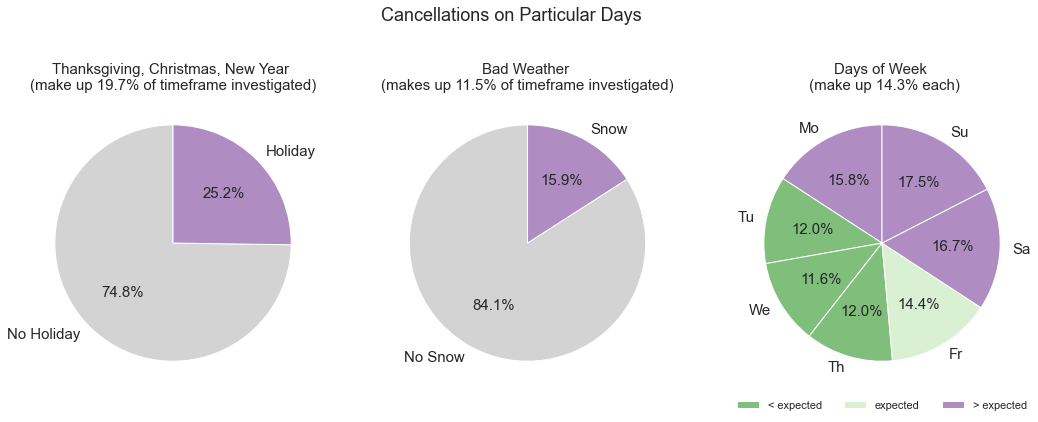

In [36]:
# holidays are 24 days (6 over thx plus 18 over xmas and ny) out of 122 (about 20%)
plt.subplot(1, 3, 1)
kwargs.update({'figsize': (18, 6), 'labels':["No Holiday", "Holiday"], 'ylabel':'', 'colors': [gy, og]})
df_cancel_67.holiday_ind_shift.value_counts().plot.pie(**kwargs); 
plt.title('Thanksgiving, Christmas, New Year \n(make up 19.7% of timeframe investigated)',fontsize=15)
# bad weather (snow) for 14 days out of 122 (about 11.5%)
plt.subplot(1, 3, 2)
kwargs.update({'labels':["No Snow", "Snow"]})
df_cancel_67.weather_shift_ind_cancel.value_counts().plot.pie(**kwargs); 
plt.title('Bad Weather \n(makes up 11.5% of timeframe investigated)', fontsize=15)
# any particular weekday should occur 14.3% of the time
plt.subplot(1, 3, 3)
kwargs.update({'colors':[og, gn, gn, gn, l_gn, og, og], 'labels':["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"] })
labels = [0,1,2,3,4,5,6]
df_cancel_67.dayOfWeek_shift.value_counts().reindex(labels).plot.pie(**kwargs);
plt.title('Days of Week \n (make up 14.3% each)', fontsize=15)
plt.legend(labels=['_hide', '< expected', '_hide', '_hide','expected', '> expected'], loc='lower center', ncol=3,  bbox_to_anchor=(0.5, -0.1), frameon=False);
plt.suptitle('Cancellations on Particular Days', fontsize=18, y=1.05);

c:\prg\mincon\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


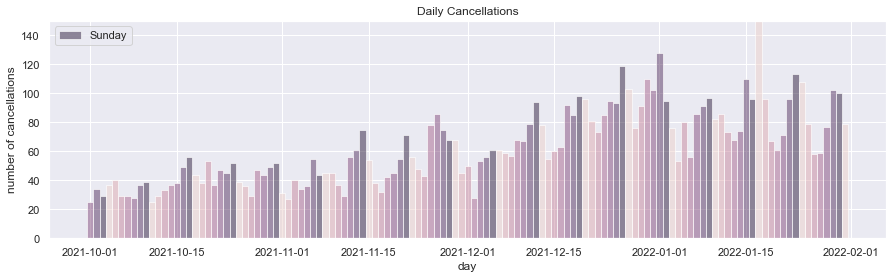

In [37]:
# another way of looking at cancellations over time, gives better idea of periodicity and trend
sns.set(rc={'figure.figsize':(15,4)})
c = sns.histplot(data=df_cancel_67, x='shift_day_cancel', binwidth=1, hue='shift_dayOfWeek_cancel');
c.set_title('Daily Cancellations')
c.set_xlabel('day')
c.set_ylabel('number of cancellations')
sns.move_legend(c, loc='upper left', title=None, labels=['Sunday'])
plt.ylim(0, 150);

### How do bookings compare to cancellations?

(3708, 12)


c:\prg\mincon\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


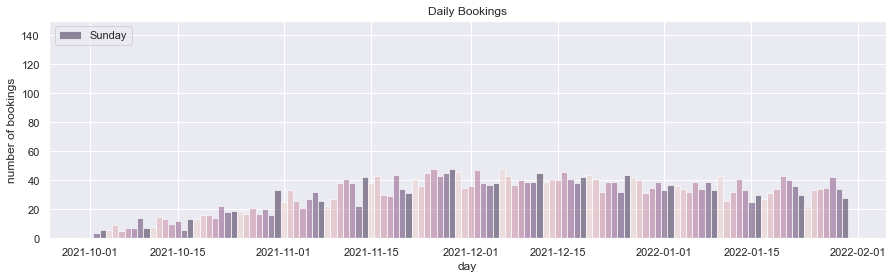

In [38]:
# compare with bookings - first need to weed out the 1000s additional facilities
# TODO: create and use df_bookings_67 earlier...
df_bookings_67 = df_bookings_4mo[df_bookings_4mo.loc[:,'facility_id_book'].isin(df_facilities['facility_id_shift'])]
print(df_bookings_67.shape)
b = sns.histplot(data=df_bookings_67, x='shift_day_book',  binwidth=1, hue='shift_dayOfWeek_book' );
b.set_title('Daily Bookings')
b.set_xlabel('day')
b.set_ylabel('number of bookings')
sns.move_legend(b, "upper left", title=None, labels=['Sunday'] ); 
plt.ylim(0, 150);

C:\Users\cwitt\AppData\Local\Temp/ipykernel_1624/3565840749.py:6: UserWarning: The label '_hide' of <matplotlib.patches.Wedge object at 0x000001544C1EBF40> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels=['> expected', '_hide', '_hide', 'expected', '_hide', '< expected'], loc='lower center', ncol=3,  bbox_to_anchor=(0.5, -0.1), frameon=False);
C:\Users\cwitt\AppData\Local\Temp/ipykernel_1624/3565840749.py:6: UserWarning: The label '_hide' of <matplotlib.patches.Wedge object at 0x000001544C1F8B80> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels=['> expected', '_hide', '_hide', 'expected', '_hide', '< expected'], loc='lower center', ncol=3,  bbox_to_anchor=(0.5, -0.1), frameon=False);
C:\Users\cwitt\AppData\Local\Temp/ipykernel_1624/3565840749.py:6: UserWarning: The label '_hide' of <matplotlib.patches.Wedge object at 0x000001544C047730> starts with '_'. It is thus excluded from the legend.
  plt.legend(labels=['> expected', '_hide', '_

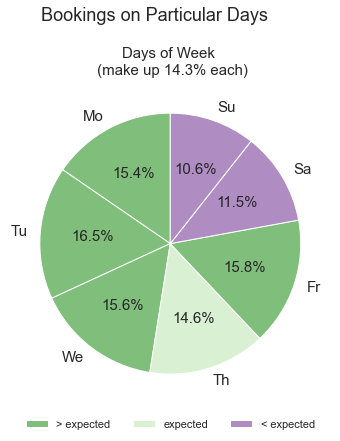

In [39]:
kwargs.update({'colors':[gn, gn, gn, l_gn, gn, og, og], 'labels':["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"] })
labels = [0,1,2,3,4,5,6]
df_bookings_67.dayOfWeek_book.value_counts().reindex(labels).plot.pie(**kwargs);
plt.title('Days of Week \n (make up 14.3% each)', fontsize=15)
plt.suptitle('Bookings on Particular Days', fontsize=18, y=1.05);
plt.legend(labels=['> expected', '_hide', '_hide', 'expected', '_hide', '< expected'], loc='lower center', ncol=3,  bbox_to_anchor=(0.5, -0.1), frameon=False);

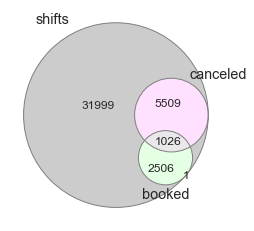

In [40]:
# check what the overlap is between shifts, booked shifts, and canceled shifts 
# since more shifts are canceled than booked, but (almost) all appear in shifts, 
# there must be some other (main) mechanism of shift assignment
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

set1 = set(df_shifts.id_shift.to_list())
set2 = set(df_cancel_67.shift_id_cancel.to_list())
set3 = set(df_bookings_67.shift_id_book.to_list())
sets = [set1, set2, set3]

v = venn3(subsets=sets, set_labels=('shifts', 'canceled', 'booked'), set_colors=['grey', 'violet', 'lightgreen'])
venn3_circles(subsets = sets, linestyle='solid', linewidth=1, color="grey")
plt.show()

### Takeaway from analysis of cancellations and bookings so far:
* Bad weather days (snow), holidays, as well as weekends and Mondays are overproportionally canceled 
* The portion of no-show cancellations is considerable: about 16%, or one out of 6
* Additionally, the portion of cancellations that happen with less than 24 hours lead time is almost half of all cancellations (the 16% no shows are included here)
* The number of cancellations increases the closer it gets to the time the shifts start
* Bookings are at a lower level than cancellations
* There are more bookings on weekdays than on weekends.


### Looking at cancellations of particular types of workers and shifts
* TODO: answer question if types of workers or shifts overproportionally cancel shifts
* need to calc cancel rate per worker type -> get number of shifts per worker type, then number of cancels per worker type

In [41]:
# look at some other variables in relation to cancellations:
# agent_req_shift, time_shift, short_shift, charge_shift, totalComp_shift
# (possibly shift_type_shift, day_shift - need to fix ranges and re-classify first)
# note: "CBH take rate is approx 22%" comment - could be staffing agency
# group by agent_req_shift, sum up , sort by agent_req_shift
# do the same for df_shifts
df_agent_cancel_by_type = df_cancel_67.groupby(by=['agent_req_shift', 'cancel_type'])['cancel_type'].count()
# note: cancel_type True is '< 24 hours lead time'
df_agent_cancel_by_type.head(15)

agent_req_shift  cancel_type    
CAREGIVER        True                  1
                 NO_CALL_NO_SHOW       3
CNA              False              3085
                 True               1936
                 NO_CALL_NO_SHOW    1045
LVN              False               587
                 True                449
                 NO_CALL_NO_SHOW     148
NURSE            False                88
                 True                143
                 NO_CALL_NO_SHOW      51
RN               False               174
                 True                 56
                 NO_CALL_NO_SHOW      14
Name: cancel_type, dtype: int64

In [42]:
# filter agent types that do not occur in large numbers in both shift and cancel table
df_agent_cancel = df_cancel_67.groupby(by=['agent_req_shift']).filter(lambda x: len(x) > 31).groupby('agent_req_shift')['id_cancel'].count().reset_index() # can count any column...
df_agent_cancel.rename(columns= {'id_cancel': 'cancel_count'}, inplace=True)
df_agent_cancel

,agent_req_shift,cancel_count
0,CNA,6066
1,LVN,1184
2,NURSE,282
3,RN,244


In [43]:
df_agent_shifts_by_type = df_shifts.groupby(by=['agent_req_shift', 'short_shift'])['short_shift'].count()
df_agent_shifts_by_type.head(18)

agent_req_shift     short_shift
CAREGIVER           False             30
                    True               1
CNA                 False          18229
                    True            6433
LVN                 False           9429
                    True            1848
Medical Aide        False              3
Medical Technician  False             11
                    True               1
NURSE               False           1550
                    True             357
PT                  False              9
RN                  False           2761
                    True             378
Name: short_shift, dtype: int64

In [44]:
# note: 'short_shift' used because some column other than agent_req_shift needs to counted (could be any)
# didn't really grok why groupby twice is needed (see https://stackoverflow.com/questions/67438726/exclude-low-sample-counts-from-pandas-groupby-calculations)
df_agent_shifts = df_shifts.groupby(by=['agent_req_shift']).filter(lambda x: len(x) > 31).groupby('agent_req_shift')['short_shift'].count().reset_index()
df_agent_shifts.rename(columns= {'short_shift': 'shift_count'}, inplace=True)
df_agent_cancel_rate = pd.merge(df_agent_shifts, df_agent_cancel, on='agent_req_shift')
df_agent_cancel_rate['cancel_rate'] = df_agent_cancel_rate.cancel_count / df_agent_cancel_rate.shift_count
df_agent_cancel_rate

,agent_req_shift,shift_count,cancel_count,cancel_rate
0,CNA,24662,6066,0.245965
1,LVN,11277,1184,0.104992
2,NURSE,1907,282,0.147876
3,RN,3139,244,0.077732


### Takeaway from first look at types of healhcare providers (agents):
* nursing assistant shifts are requested most, next are vocational nurses, and fewer registered nurses
* the profile seems to fit a nursing home more than a hospital
* comparison data:
https://www.statista.com/statistics/824849/staff-numbers-in-us-community-hospital-facilities/
https://www.statista.com/statistics/858606/nursing-home-employee-occupations-distribution-us/
(https://www.statista.com/statistics/882437/distribution-of-health-center-medical-staff-by-type-us/)
* since nursing assistant's cancel rate is much higher than that of others, the facility type (with its characteristic composition of providers) could determine its cancel rate / booking rate.

In [45]:
# merge shift data to bookings to get agent types of bookings
df_bookings_67_mrg = pd.merge(df_bookings_67, df_shifts, how='inner', left_on='shift_id_book', right_on='id_shift')
df_agent_book = df_bookings_67_mrg.groupby(by=['agent_req_shift']).filter(lambda x: len(x) > 31).groupby('agent_req_shift')['id_book'].count().reset_index() # can count any column...
df_agent_book.rename(columns= {'id_book': 'book_count'}, inplace=True)
df_agent_all_rates = pd.merge(df_agent_cancel_rate, df_agent_book, on='agent_req_shift')
df_agent_all_rates['book_rate'] = df_agent_all_rates.book_count / df_agent_all_rates.shift_count
df_agent_all_rates.head()

,agent_req_shift,shift_count,cancel_count,cancel_rate,book_count,book_rate
0,CNA,24662,6066,0.245965,2644,0.107209
1,LVN,11277,1184,0.104992,892,0.079099
2,NURSE,1907,282,0.147876,48,0.025170
3,RN,3139,244,0.077732,123,0.039184


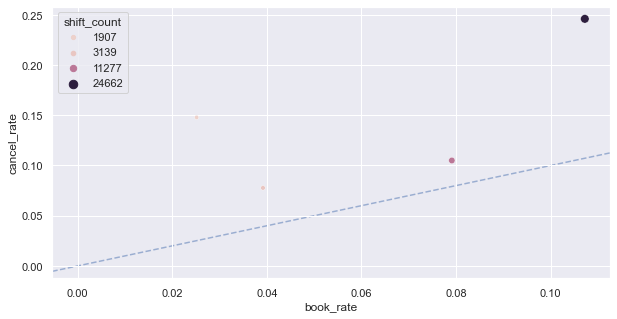

In [46]:
#sns.plot(data=df_agent_cancel_rate, x='cancel_rate', hue='agent_req_shift')
sns.set(rc={'figure.figsize':(10, 5)})
ax = sns.scatterplot(data=df_agent_all_rates, x='book_rate', y='cancel_rate', hue='shift_count', size='shift_count');
ax.axline((0, 0), slope=1, c="b", ls="--", alpha=0.5,  zorder=0);

In [47]:
# is there an easier way? also, need agent median shift length, median charge, 
# shift_length_median, cancel_length_median, shift_charge_median, cancel_charge_median
df_comp_shift = df_shifts.groupby(by=['agent_req_shift']).filter(lambda x: len(x) > 31).groupby('agent_req_shift')[['time_shift', 'charge_shift', 'totalComp_shift']].mean().reset_index()
df_comp_shift

,agent_req_shift,time_shift,charge_shift,totalComp_shift
0,CNA,7.160954,34.797928,193.378773
1,LVN,8.464558,49.257625,328.884636
2,NURSE,8.179566,41.418520,264.252718
3,RN,8.180062,65.580099,426.073929


In [48]:
df_comp_cancel =  df_cancel_67.groupby(by=['agent_req_shift']).filter(lambda x: len(x) > 31).groupby('agent_req_shift')[['time_shift', 'charge_shift', 'totalComp_shift']].mean().reset_index()
df_comp_cancel 

,agent_req_shift,time_shift,charge_shift,totalComp_shift
0,CNA,7.388019,35.024886,201.154301
1,LVN,8.658780,50.436529,344.041266
2,NURSE,8.962979,41.418520,289.561983
3,RN,8.277236,66.302322,434.904038
